# Author: Keith Patarroyo https://keithpatarroyo.wordpress.com/

# 1D Inhomogenious non-linear Heat Equation solution with FEM: 
# $$ \frac{\partial u(x,t)}{\partial t}- \frac{\partial}{\partial x}\left(k(x)\frac{\partial u(x,t)}{\partial x}\right)+[2+\sin(u(x))]=f(x)$$

# using Dirichlet Conditions in $[0,1]$

In [1]:
%matplotlib nbagg 
# Enables interaction with images
import numpy as np # to manupulate Matrices and solve Linear Systems
import matplotlib.pyplot as plt # Plot the Numerical and Analitic solution to the Differential Equation
from matplotlib import animation # Library to make animations(make sure you have ffmpeg installed in linux)
from scipy.integrate import odeint # Solve system of differential equations
import io # To display videos on the Notebook
import base64 # To display videos on the Notebook
from IPython.display import HTML # To display videos on the Notebook
from mpl_toolkits.mplot3d import Axes3D # To do 3-D Plots
from __future__ import unicode_literals # For unicode utf-8 characters in the labels of plots
from matplotlib import cm # color map for plots in matplotlib 
from matplotlib.ticker import LinearLocator, FormatStrFormatter # Better ticks in the 3d plots

In [2]:
# Integration with Gauss-Legendre Quadrature
omega_aux = [5./9.,8./9.,5./9.] # Quadrature Weights for a three point integration
p_aux = [-np.sqrt(15.)/5.,0.,+np.sqrt(15.)/5.] # Quadrature points for an integration on the interval [-1,1]

In [3]:
class Element:
    """This class contains all the relevant atributes of the Triangulation Element in 1D """
    
    def __init__(self,index,Tinterval,N):
        
        self.index = index #Index of the element, it can be a number between 1 to N
        a = Tinterval[0] # left endpoint of interval (a,b)
        b = Tinterval[1] # right endpoint of interval (a,b)
        self.interval = [float(a)+float(index-1)*(float(b-a)/float(N)),float(a)+float(index)*(float(b-a)/float(N))] # interval of the Element
        self.length = self.interval[1]-self.interval[0] # Length of the element, for a uniform grid (this case) its equal for all, other grids (not always = lenght for all)
        self.dphi_i = -1./self.length # derivative of \phi_i 
        self.dphi_ii = 1./self.length # derivative of \phi_i+1
        self.enum = [index,index+1] # setting up the enumeration of the Elements
        self.omega = [0.5*self.length*x for x in omega_aux] # Rescaleted weights for integration in the interval of the element
        self.x_q = [self.interval[0] + 0.5*(1.+x)*self.length for x in p_aux] # Rescaleted quadrature points for integration in the interval of the element
        self.int_phi_i = [(self.interval[1]-x)/(self.length) for x in self.x_q] # Base phi_i evaluated in the quadrature points
        self.int_phi_ii = [(x-self.interval[0])/(self.length) for x in self.x_q] # Base phi_ii evaluated in the quadrature points
        self.int_dphi_i = [self.dphi_i for x in range(3)] # Derivateve of base phi_i evaluated in the quadrature points
        self.int_dphi_ii = [self.dphi_ii for x in range(3)] # Derivateve of base phi_ii evaluated in the quadrature points
    
    def phi_i(self,x):
        # Correspondent phi_i function to the given element
        return (self.interval[1]-x)/(self.length)
    
    def phi_ii(self,x):
        # Correspondent phi_i+1 function to the given element
        return (x-self.interval[0])/(self.length)
    
    def setlocalMatrixSpace(self,a11,a12,a21,a22):
        # this function sets up the local matrix A (matrix for spatial derivative) corresponding to the element
        self.localMatrixSpace = np.array([[a11,a12],[a21,a22]])
        
    def setlocalMatrixTime(self,m11,m12,m21,m22):
        # this function sets up the local matrix M (matrix for time derivative) corresponding to the element
        self.localMatrixTime = np.array([[m11,m12],[m21,m22]])
    
    def setlocalside_b(self,b1,b2):
        # this function sets up the local side b corresponding to the element
        self.localside_b = np.array([b1,b2])
        
    def setlocalside_mm(self,mm1,mm2):
        # this function sets up the nonlinear local side mm corresponding to the element
        self.localside_mm = np.array([mm1,mm2])

## 1. Solution of the problem with $k(x)=1$, $ f(x)=0$ 
# $$ \frac{\partial u(x,t)}{\partial t}- \frac{\partial^2 u(x,t)}{\partial x^2}+[2+\sin(u(x))]=0$$

##  Using Dirichlet boundary conditions $u(0,t)=0$ and $u(1,t)=1$

## With initial condition  $u(x,0)=x^2$ and in the interval $x \in [0,1]$

In [4]:
def setProblem():
    """Setting up of the Problem parameters"""
    interval = [0.,1.]
    return interval,lambda x: 0., lambda x: 1

In [5]:
# Setting problem up and making of all  elements
interval,f,k = setProblem() # initialising the interval of solution and functions f(x) and k(x)
partitions = 7# number of partitions in the 1D Solution Grid
steps = 10000001. # number of time steps of solution 
total_t = 0.05 # Total interval of time (0,total_t) 
delta_t = total_t/steps # time step
listElements = [] # All elements(objects) of the Grid are stored in this list for convenience
for i in xrange(partitions): # Set the atributes for all elements, each corresponing to an interval
    Elementi = Element(i+1,interval,partitions)
    listElements.append(Elementi)

In [6]:
# Setting up the all local matrices

for e in listElements:#The matrix elements a_ij, m_ij  and the side b_i are computed with the galerkin method results
    #Assembly of local matrices a_ij (matrix for spatial derivative)
    a11 = sum([x*x*y*k(z) for x,y,z in zip(e.int_dphi_i,e.omega,e.x_q)])
    a12 = sum([x*y*z*k(w) for x,y,z,w in zip(e.int_dphi_i,e.int_dphi_ii,e.omega,e.x_q)])
    a22 = sum([x*x*y*k(z) for x,y,z in zip(e.int_dphi_ii,e.omega,e.x_q)])
    e.setlocalMatrixSpace(a11,a12,a12,a22)
    #Assembly of local matrices m_ij (matrix for time derivative)
    m11 = sum([x*x*y for x,y in zip(e.int_phi_i,e.omega)])
    m12 = sum([x*y*z for x,y,z in zip(e.int_phi_i,e.int_phi_ii,e.omega)])
    m22 = sum([x*x*y for x,y in zip(e.int_phi_ii,e.omega)])
    e.setlocalMatrixTime(m11,m12,m12,m22)
    #Assembly of local sides b_i
    b1 = sum([x*y*(f(z)-2.) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
    b2 = sum([x*y*(f(z)-2.) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
    e.setlocalside_b(b1,b2)

In [7]:
# Setting up the Global matrices M, A and global side b

A = np.zeros((partitions+1,partitions+1))
M = np.zeros((partitions+1,partitions+1))
b = np.zeros((partitions+1,1))
for e in listElements:# Setting up the Global matrices and Global side using the contribution of each element
    #Assembly of Global matrix A (matrix for spatial derivative)
    A[e.index-1][e.index-1] +=e.localMatrixSpace[0][0]
    A[e.index-1][e.index] +=e.localMatrixSpace[0][1] 
    A[e.index][e.index-1] +=e.localMatrixSpace[1][0]  
    A[e.index][e.index] +=e.localMatrixSpace[1][1]
    #Assembly of Global matrix M (matrix for time derivative)
    M[e.index-1][e.index-1] +=e.localMatrixTime[0][0]
    M[e.index-1][e.index] +=e.localMatrixTime[0][1] 
    M[e.index][e.index-1] +=e.localMatrixTime[1][0]  
    M[e.index][e.index] +=e.localMatrixTime[1][1]  
    #Assembly of Global side b
    b[e.index-1] += e.localside_b[0]
    b[e.index] += e.localside_b[1]

print A.shape
print M.shape
print b.shape

(8, 8)
(8, 8)
(8, 1)


### 1.1  Using Dirichlet boundary conditions $u(0,t)=0$ and $u(1,t)=1$

In [8]:
# setting up the dirichlet boundary conditions
alpha_d = np.zeros((partitions+1,1))
alpha_d[0]=0.# boundary condition u(0)=0
alpha_d[-1]=1.# boundary condition u(1)=1
b_l=b-np.dot(M, alpha_d)# Updating the local side with the boundary conditions
print b_l.shape

(8, 1)


In [9]:
#Updating the linear system to a dirichlet transformed system
A_1=A
M_1=M
b_1=b_l
A_1 = np.delete(A_1, (0), axis=0) #updating A to the B.C.
A_1 = np.delete(A_1, (-1), axis=0)
A_1 = np.delete(A_1,(0), axis=1)
A_1 = np.delete(A_1,(-1), axis=1)
M_1 = np.delete(M_1, (0), axis=0) #updating M to the B.C.
M_1 = np.delete(M_1, (-1), axis=0)
M_1 = np.delete(M_1,(0), axis=1)
M_1 = np.delete(M_1,(-1), axis=1)
b_1 = np.delete(b_1, (0), axis=0) #updating b to the B.C.
b_1 = np.delete(b_1, (-1), axis=0)

### 1.1.1  Solving system and implementing initial condition
### $$\text{I.C.}\begin{cases} u(x,0)=x^2, \ \ x \in [0,1] \end{cases}$$

In [ ]:
#Solving the linear ODE system with dirichlet transformed system(explicit euler)
A_net = (M_1)
x_i = np.array([((1./partitions)*(i+1.))**2 for i in xrange(partitions-1)]) # initial condition function coefficients of u(0,x)=x 
print x_i.shape
sol = np.zeros([int(steps-1),partitions+1])
print sol.shape
sol[0][:] = np.squeeze(np.append(np.append([[alpha_d[0]]],x_i), [[alpha_d[-1]]]))
#print sol[1][:]
for i in xrange(int(steps)-2):
    
      # Setting up the all non-linear local side

    for e in listElements:#The sides mm1,mm2 are computed with the galerkin method results
        mm1 = sum([x*y*np.sin(sol[i][e.index-1]*e.phi_i(z)+sol[i][e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_i,e.omega,e.x_q)])
        mm2 = sum([x*y*np.sin(sol[i][e.index-1]*e.phi_i(z)+sol[i][e.index]*e.phi_ii(z)) for x,y,z in zip(e.int_phi_ii,e.omega,e.x_q)])
        e.setlocalside_mm(mm1,mm2)

    # Setting up the non-linear  global side mm

    mm = np.zeros((partitions+1,1))
    for e in listElements:# Setting up the non-linearglobal side mm using the contribution of each element 
        mm[e.index-1] += e.localside_mm[0]
        mm[e.index] += e.localside_mm[1]

    #Solving the linear system with dirichlet transformed system
    mm_1=mm
    mm_1 = np.delete(mm_1, (0), axis=0) #updating mm to the B.C.
    mm_1 = np.delete(mm_1, (-1), axis=0)

    b_net = delta_t*(b_1-mm_1)+np.transpose([M_1.dot(np.squeeze(x_i))]) - delta_t*np.transpose([A_1.dot(np.squeeze(x_i))])
    x_ii = np.linalg.solve(A_net,np.squeeze(b_net))
    x_ii_1 = np.append([[alpha_d[0]]],x_ii)
    x_ii_1 = np.append(x_ii_1, [[alpha_d[-1]]])
    sol[i+1][:] = x_ii_1
    x_i = np.array([x_ii])
    if i%100000 == 0:
        print i
print sol.shape
#print sol[1][:]

(6,)
(10000000, 8)
0
100000
200000
300000


In [502]:
#Plot of the Numerical solution for t =0
y = np.linspace(interval[0],interval[1],partitions+1) #Plot of numerical solution
plt.plot(y,sol[0],'r')
plt.show()

<IPython.core.display.Javascript object>


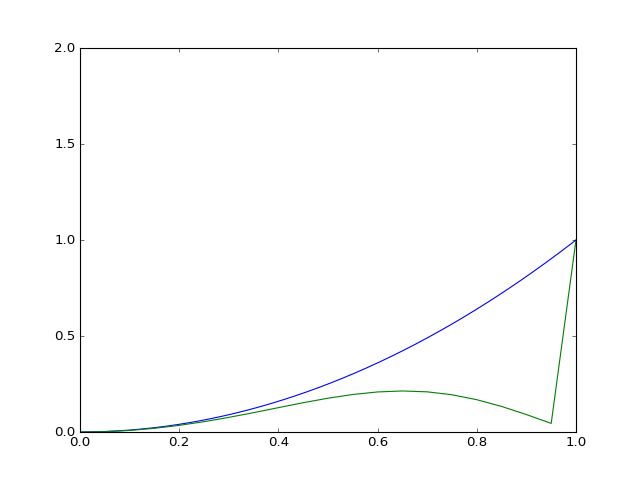

In [444]:
#Animation of the Numerical  solution 

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 2))
N1 = 2 # 1 initial condition + 1 for the the approximate solution
lines = [plt.plot([], [])[0] for _ in range(N1)]

# initialization function: plot the background of each frame
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# animation function.  This is called sequentially
def animate(i):
    for j,line in enumerate(lines):
        if(j==0):
            x = np.linspace(-2., 2., 1000)
            line.set_data(x, x**2)
        if(j==1):
            x = np.linspace(interval[0],interval[1],partitions+1)
            y = sol[i*10000]
            line.set_data(x, y)
            
    return lines

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html

anim.save('basic_animation4.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

<IPython.core.display.Javascript object>


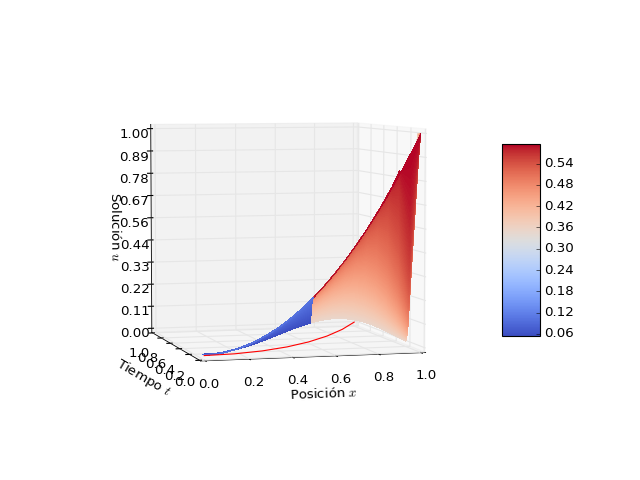

In [445]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0.0, 1.0+1./partitions, 1./partitions)
t = np.arange(0.0, total_t-delta_t*1000, delta_t*1000)
X, Y = np.meshgrid(x, t)

Z = np.zeros((t.shape[0],x.shape[0]))
for i in xrange(t.shape[0]):
    Z[i][:]=sol[1000*i][:]

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_ylabel('Tiempo $t$ ')
ax.set_xlabel('Posición $x$ ')
ax.set_zlabel('Solución $u$ ')

plt.show()

In [446]:
video = io.open('basic_animation4.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))